# SWB Regression Pipeline - Gamma Power 
Created: 07/30/24 \
Updated: 08/22/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08222024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [12]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
band = 'gamma'
gamma_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
gamma_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [10]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
    roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [11]:
# ####### NEW DATA FRAME 
gamma_reg_df = gamma_df.copy()
gamma_reg_df = gamma_reg_df[gamma_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(gamma_reg_df,reg_formula,
                                                            elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3032.63it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3254.42it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3116.38it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3263.04it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2962.28it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2936.36it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3156.89it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [14]:
results = single_elec_permutation_results(results_dict,gamma_reg_df,save_vars)
results



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.024224,-0.043347,-0.041232,0.027068,-0.005897,0.000195,...,0.019257,0.018696,2.108390,-2.108390,-2.185222,1.526166,0.034997,0.034997,0.028873,0.126969
1,MS002_lacas2-lacas3,MS002,acc,14,0.008572,-0.018996,-0.001146,0.037122,-0.005029,0.000666,...,0.020595,0.019852,0.912791,-0.912791,-0.004845,1.811202,0.361352,0.361352,0.996134,0.070110
2,MS002_lacas3-lacas4,MS002,acc,14,0.008432,-0.012893,-0.010174,0.031131,-0.000795,0.000446,...,0.017278,0.016557,0.737616,-0.737616,-0.642922,1.907435,0.460748,0.460748,0.520275,0.056464
3,MS002_lacas4-lacas5,MS002,acc,14,0.015133,-0.010722,-0.025810,0.028943,0.008128,-0.000597,...,0.017591,0.017522,0.513304,-0.513304,-1.482109,1.660763,0.607739,0.607739,0.138311,0.096761
4,MS002_lacas5-lacas6,MS002,acc,14,0.015954,-0.017147,-0.020481,-0.019122,0.003831,0.000377,...,0.015353,0.015351,1.010638,-1.010638,-1.316901,-1.180474,0.312190,0.312190,0.187872,0.237812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,DA039_rpins6-rpins7,DA039,stg,22,0.004477,-0.059507,0.050602,-0.051201,-0.018163,-0.000444,...,0.043853,0.046196,1.260250,-1.260250,1.143102,-1.121043,0.207579,0.207579,0.252996,0.262269
1616,DA039_rpins7-rpins8,DA039,stg,22,-0.005000,-0.031559,0.039599,-0.058016,-0.016303,-0.002072,...,0.040569,0.040618,0.729831,-0.729831,1.048807,-1.461746,0.465493,0.465493,0.294267,0.143811
1617,DA039_rpins8-rpins9,DA039,stg,22,0.003383,-0.026483,0.035055,-0.034728,-0.007019,0.000654,...,0.043219,0.042883,0.620064,-0.620064,0.844595,-0.801440,0.535215,0.535215,0.398337,0.422877
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.113602,0.017682,0.066583,0.043671,-0.107104,0.000729,...,0.037222,0.036427,-0.449338,0.449338,1.822879,1.193048,0.653188,0.653188,0.068322,0.232850


In [15]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{date}.pkl',"wb"))




In [16]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
9,MS002_lagit1-lagit2,MS002,amy,14,0.024441,-0.043570,0.009462,0.036818,-0.005974,0.000396,...,0.018356,0.017139,2.273351,-2.273351,0.528125,2.212121,0.023005,0.023005,0.597413,0.026958
22,MS002_laims11-laims12,MS002,dmpfc,14,-0.019313,0.000914,0.004536,0.043911,-0.018223,-0.000662,...,0.016891,0.017175,-0.084872,0.084872,0.288327,2.574108,0.932363,0.932363,0.773096,0.010050
58,MS002_racas6-racas7,MS002,dmpfc,14,-0.000124,0.019462,-0.036641,-0.063790,0.013312,0.000040,...,0.018321,0.017762,-1.005658,1.005658,-1.985129,-3.558521,0.314580,0.314580,0.047130,0.000373
59,MS002_racas7-racas8,MS002,dmpfc,14,-0.004943,0.026748,-0.011590,-0.047181,0.013642,-0.000117,...,0.016121,0.016629,-1.535844,1.535844,-0.711351,-2.835651,0.124577,0.124577,0.476867,0.004573
60,MS002_racas8-racas9,MS002,dmpfc,14,-0.007288,0.011024,0.003558,-0.050737,0.000892,-0.000799,...,0.016392,0.016647,-0.680834,0.680834,0.258717,-3.062415,0.495977,0.495977,0.795854,0.002196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,DA037_rmins1-rmins2,DA037,pins,4,-0.031844,-0.007945,0.011144,0.036593,-0.033443,-0.001149,...,0.017318,0.017005,0.347471,-0.347471,0.606702,2.132901,0.728238,0.728238,0.544049,0.032933
1565,DA037_rof1-rof2,DA037,ofc,4,-0.083822,-0.009986,0.067462,0.116941,-0.086022,-0.000639,...,0.040658,0.038325,0.206657,-0.206657,1.638114,3.062061,0.836278,0.836278,0.101398,0.002198
1599,DA039_rof1-rof2,DA039,ofc,22,-0.196157,-0.059164,0.018557,0.112557,-0.218919,0.000215,...,0.039403,0.040825,1.415637,-1.415637,0.413898,2.738940,0.156882,0.156882,0.678949,0.006164
1603,DA039_rof5-rof6,DA039,ofc,22,-0.223541,0.000910,-0.020782,0.089453,-0.223186,-0.000016,...,0.031958,0.033291,-0.028900,0.028900,-0.694883,2.693799,0.976944,0.976944,0.487128,0.007064


In [17]:
sig_data.roi.value_counts()



ofc         30
acc         21
dmpfc       20
amy         18
ains        12
dlpfc       12
vlpfc       10
hpc         10
stg          7
sts          6
thalamus     6
smg          6
pins         4
mtg          3
Name: roi, dtype: int64

In [18]:
sig_data.roi.unique()



array(['amy', 'dmpfc', 'dlpfc', 'hpc', 'mtg', 'ofc', 'ains', 'vlpfc',
       'acc', 'stg', 'sts', 'pins', 'smg', 'thalamus'], dtype=object)

In [19]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


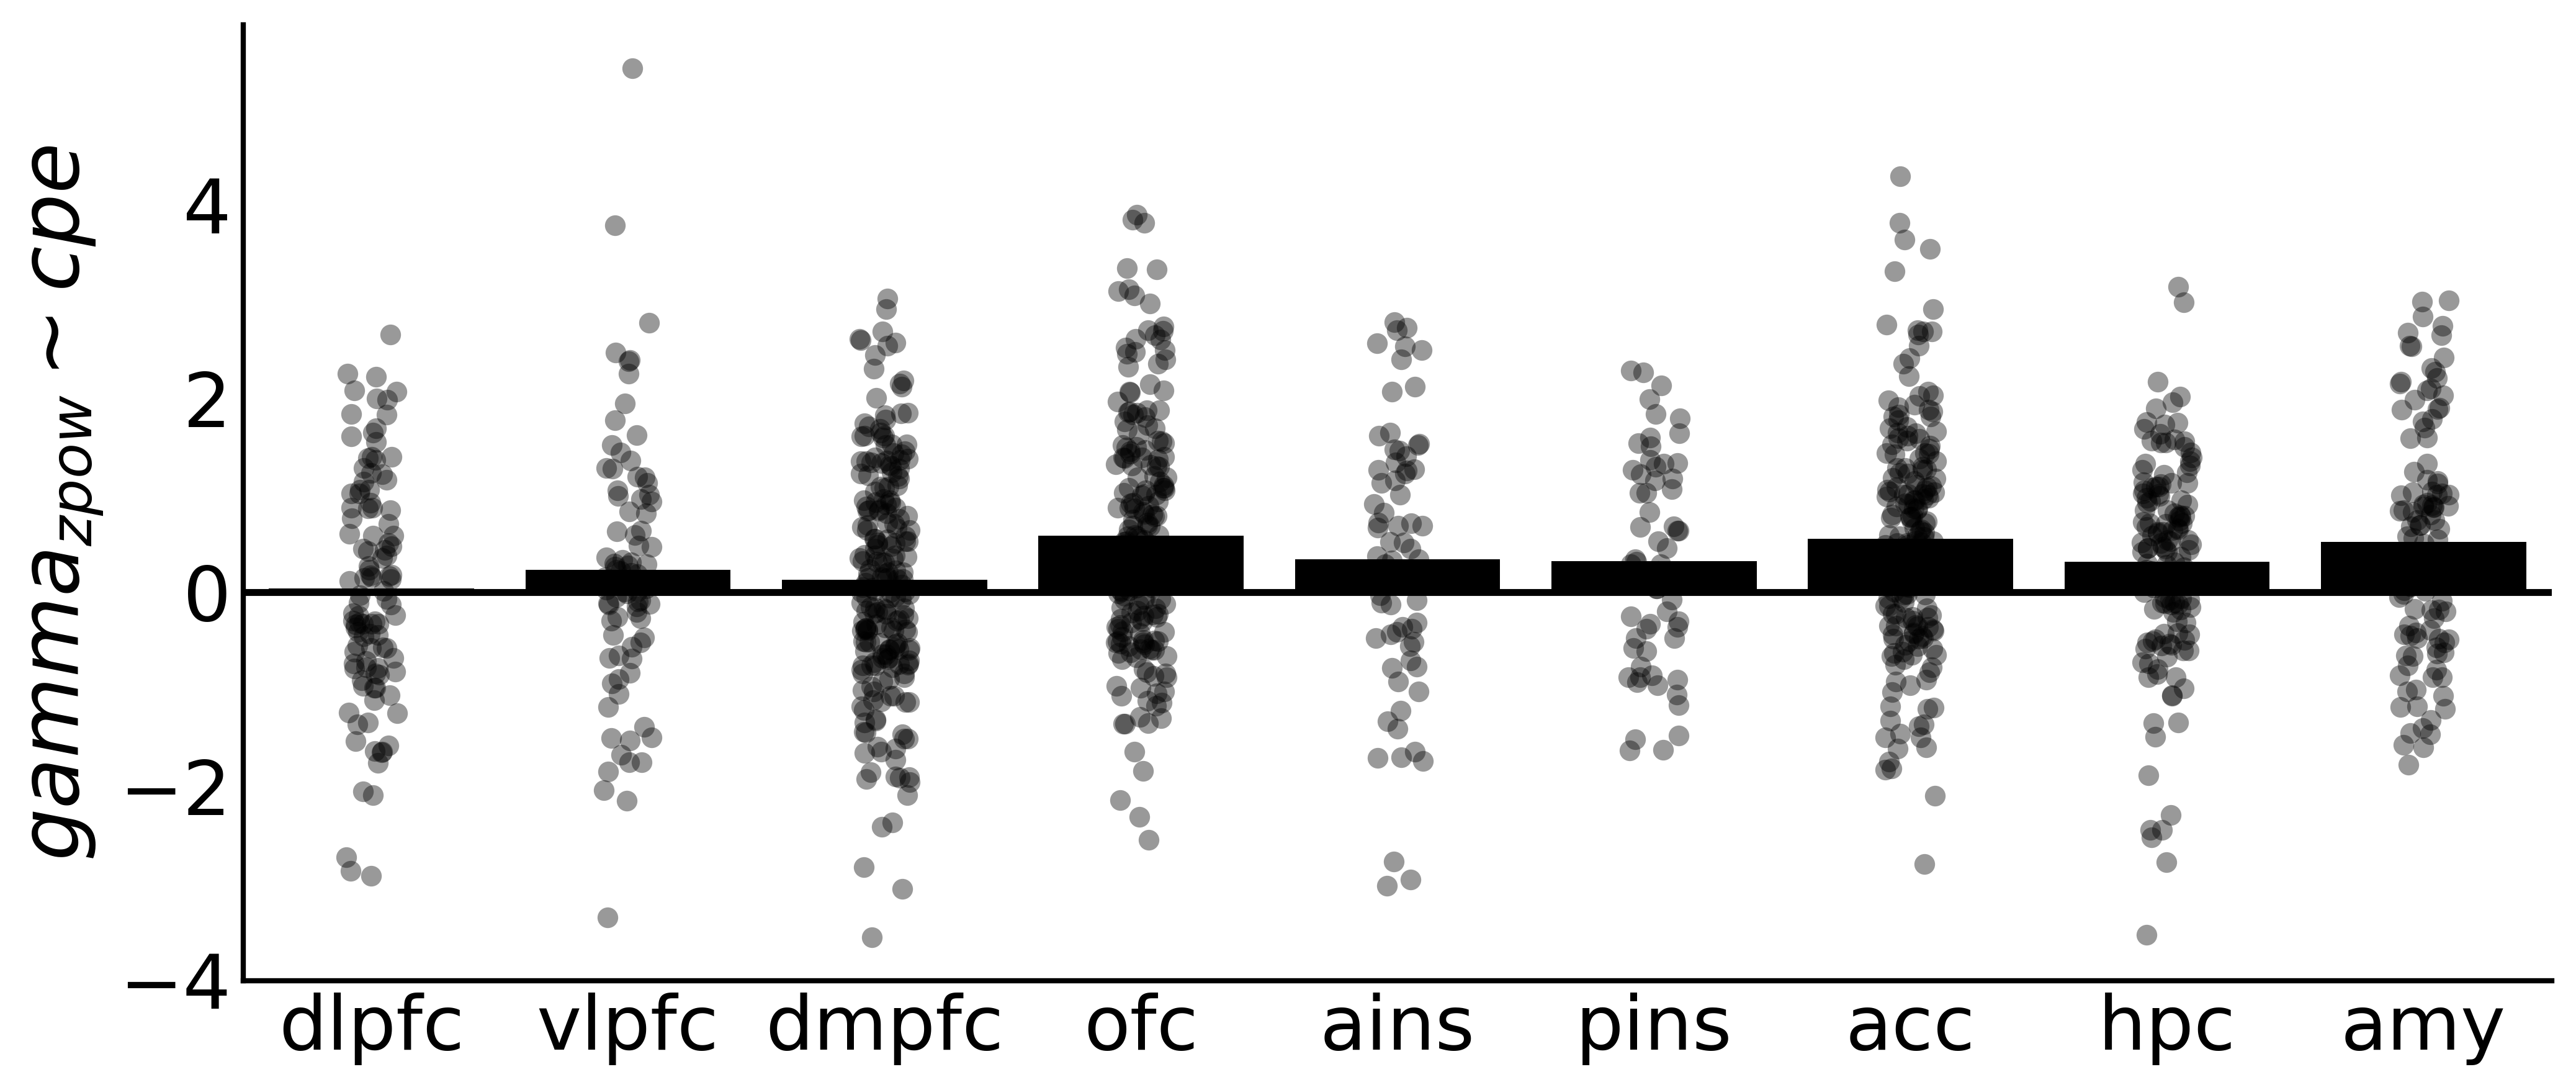

In [20]:
# plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,4),color='k')
# green '#135546'

ylabel = fr'${band}_{{zpow}} \sim cpe$'
fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_single_elec_roi_barplot.pdf'

plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_dir,fig_id=fig_id,dpi=400)





In [21]:
results.to_csv(f'{fig_save_dir}{band}_single_elec_perm_results.csv')

In [22]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]



roi
dlpfc    0.041204
vlpfc    0.227834
dmpfc    0.126233
ofc      0.581983
ains     0.341742
pins     0.321635
acc      0.548175
hpc      0.313923
amy      0.521972
Name: Z_Score_decisionCPE, dtype: float64

In [23]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.024224,-0.043347,-0.041232,0.027068,-0.005897,0.000195,...,0.019257,0.018696,2.108390,-2.108390,-2.185222,1.526166,0.034997,0.034997,0.028873,0.126969
1,MS002_lacas2-lacas3,MS002,acc,14,0.008572,-0.018996,-0.001146,0.037122,-0.005029,0.000666,...,0.020595,0.019852,0.912791,-0.912791,-0.004845,1.811202,0.361352,0.361352,0.996134,0.070110
2,MS002_lacas3-lacas4,MS002,acc,14,0.008432,-0.012893,-0.010174,0.031131,-0.000795,0.000446,...,0.017278,0.016557,0.737616,-0.737616,-0.642922,1.907435,0.460748,0.460748,0.520275,0.056464
3,MS002_lacas4-lacas5,MS002,acc,14,0.015133,-0.010722,-0.025810,0.028943,0.008128,-0.000597,...,0.017591,0.017522,0.513304,-0.513304,-1.482109,1.660763,0.607739,0.607739,0.138311,0.096761
4,MS002_lacas5-lacas6,MS002,acc,14,0.015954,-0.017147,-0.020481,-0.019122,0.003831,0.000377,...,0.015353,0.015351,1.010638,-1.010638,-1.316901,-1.180474,0.312190,0.312190,0.187872,0.237812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,DA039_rpins1-rpins2,DA039,pins,22,0.005609,0.000551,0.017538,-0.040383,0.005765,0.000144,...,0.024562,0.024233,-0.016597,0.016597,0.715301,-1.629908,0.986758,0.986758,0.474423,0.103121
1611,DA039_rpins2-rpins3,DA039,pins,22,0.010169,-0.023231,0.033972,-0.027158,0.001258,0.000015,...,0.029017,0.029481,0.782696,-0.782696,1.162830,-0.902833,0.433806,0.433806,0.244898,0.366615
1612,DA039_rpins3-rpins4,DA039,pins,22,-0.002262,-0.032962,0.068208,-0.041101,-0.014403,-0.001289,...,0.037687,0.039420,0.840099,-0.840099,1.803813,-1.055070,0.400853,0.400853,0.071261,0.291393
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.113602,0.017682,0.066583,0.043671,-0.107104,0.000729,...,0.037222,0.036427,-0.449338,0.449338,1.822879,1.193048,0.653188,0.653188,0.068322,0.232850


In [24]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))

    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)



In [25]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.548175
ains,0.341742
amy,0.521972
dlpfc,0.041204
dmpfc,0.126233
hpc,0.313923
ofc,0.581983
pins,0.321635
vlpfc,0.227834


In [26]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data[['Z_Score_decisionCPE','rho','rho_p']]



,Z_Score_decisionCPE,rho,rho_p
roi,,,
acc,0.548175,-0.101493,0.1602
dmpfc,0.126233,-0.200554,0.0031
amy,0.521972,-0.267952,0.0041
ains,0.341742,-0.307096,0.0092
vlpfc,0.227834,-0.152934,0.1702
hpc,0.313923,-0.176850,0.0402
ofc,0.581983,0.052982,0.4539
pins,0.321635,0.106121,0.4197
dlpfc,0.041204,-0.188915,0.0513


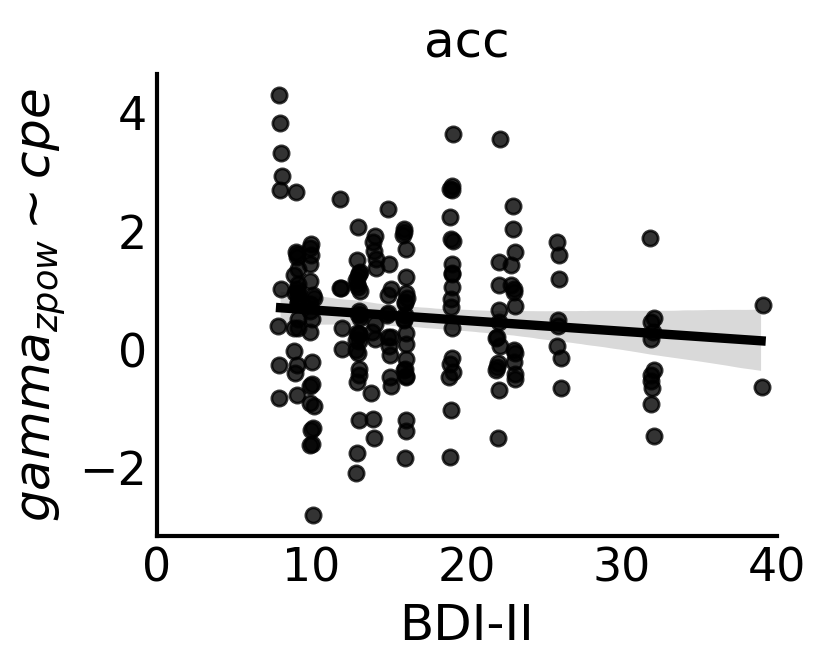

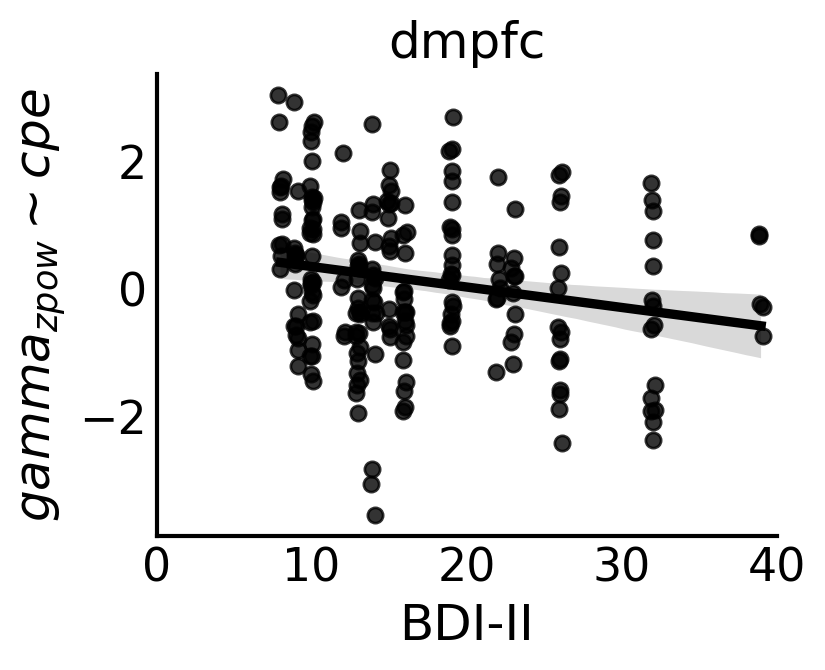

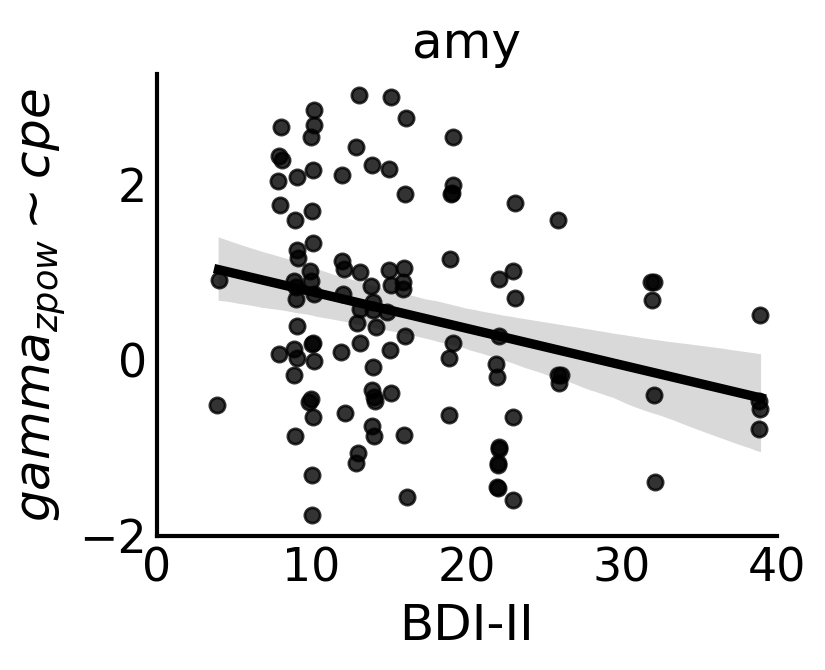

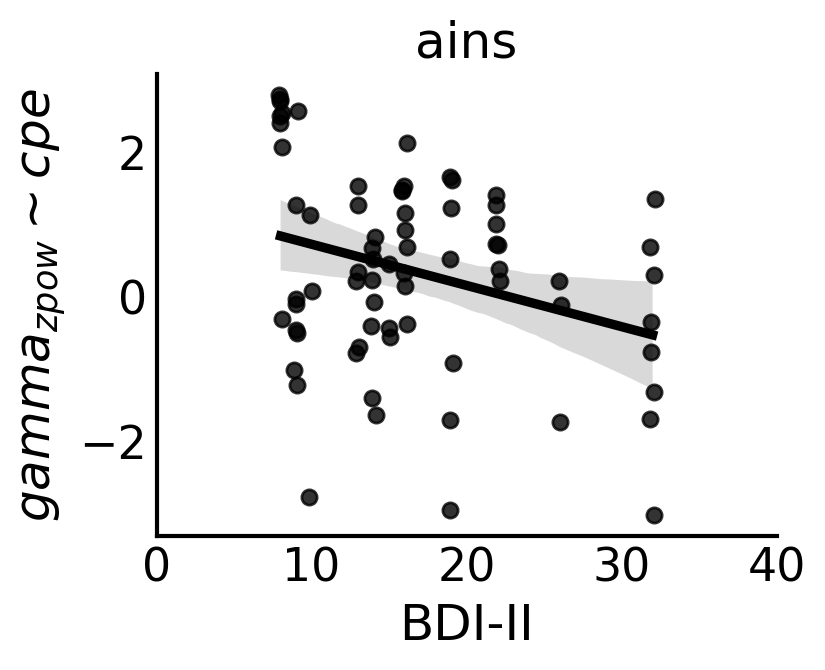

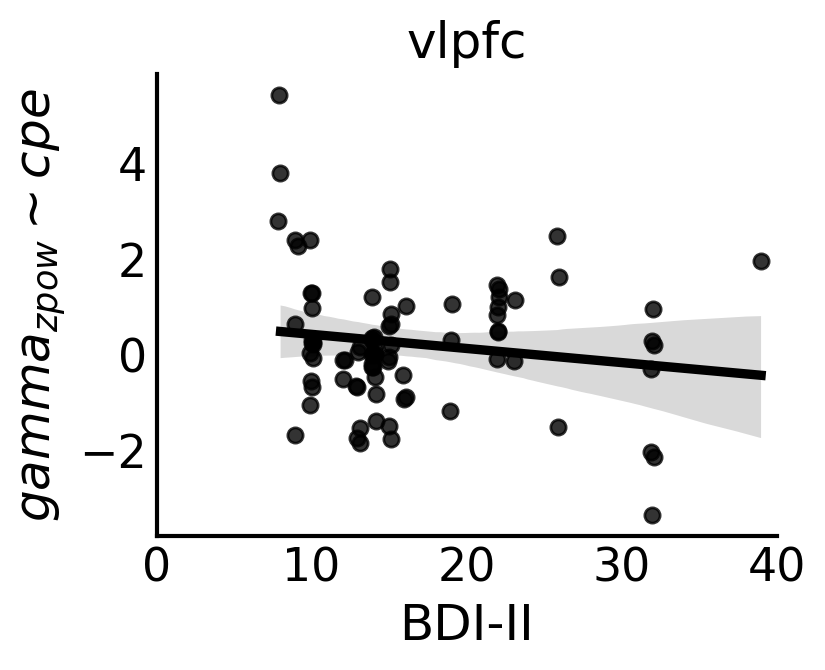

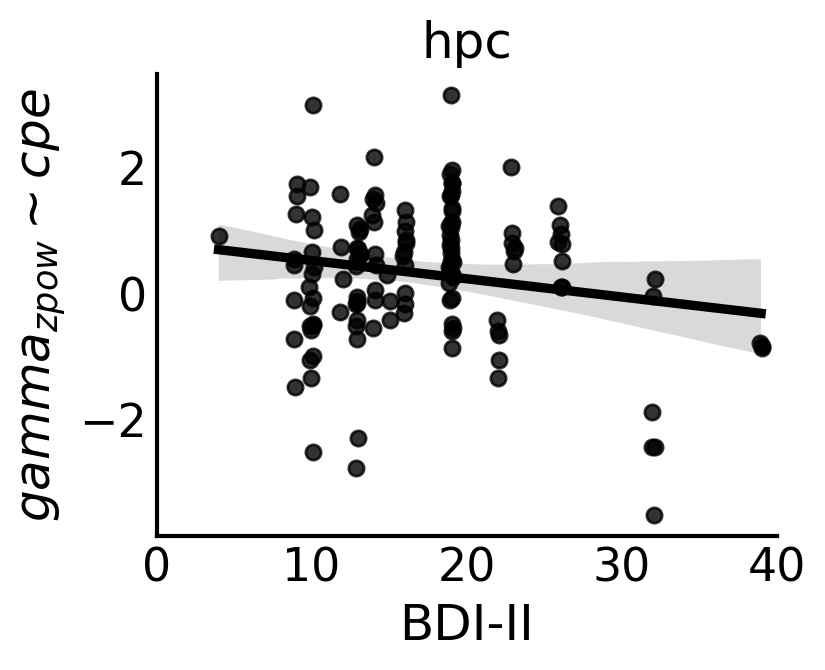

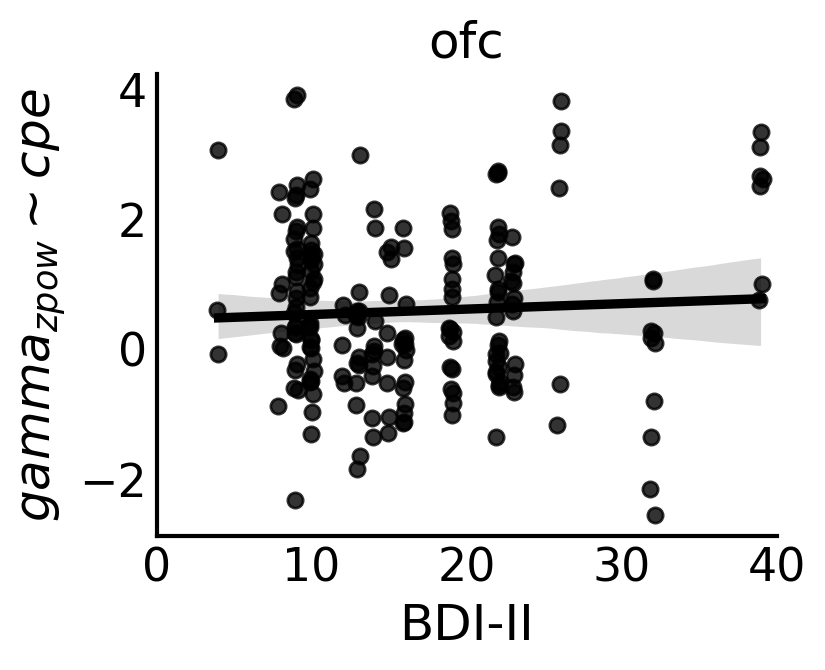

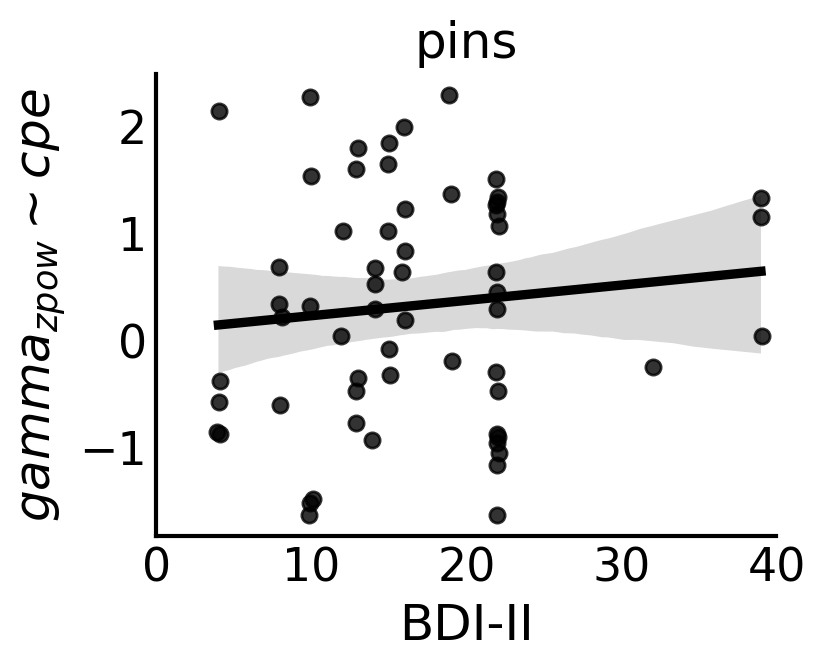

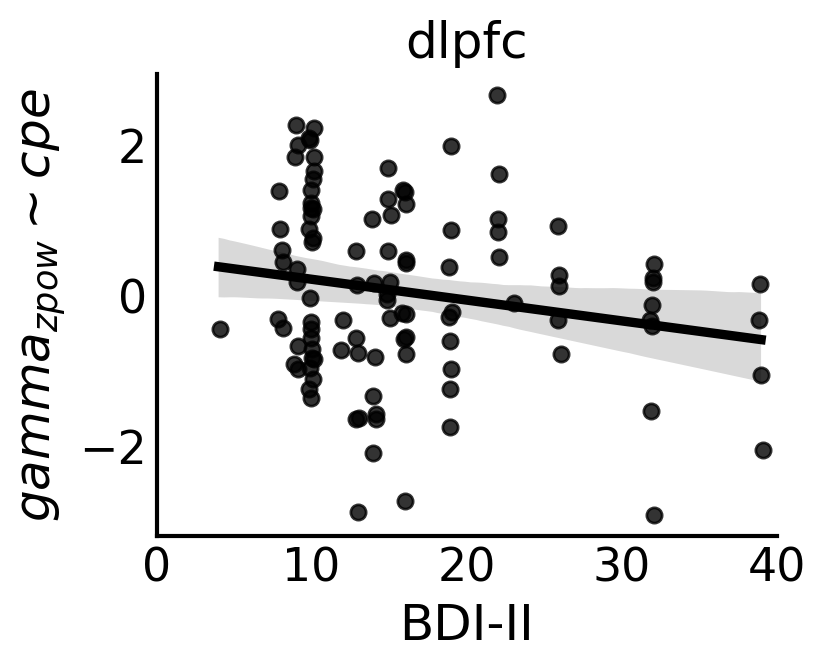

In [27]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter.pdf'
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975

    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()
    
    
    plt.savefig(f'{fig_save_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [28]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 22 Aug 2024                                         
Time:                        17:02:53                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1059      0.488     33.017     